## Few Final Fixes

In [ ]:
import os
import tensorflow as tf

#Use the splitted_dataset from MobileNet V3 small.
train_dir = 'C:/Users/leong/OneDrive/Desktop/24S2 NYP/EGT215 Computer Vision/UPDATED_CV_MODEL/FloraV13/TF_Datasets/Train'
validation_dir = 'C:/Users/leong/OneDrive/Desktop/24S2 NYP/EGT215 Computer Vision/UPDATED_CV_MODEL/FloraV13/TF_Datasets/Val'
test_dir = 'C:/Users/leong/OneDrive/Desktop/24S2 NYP/EGT215 Computer Vision/UPDATED_CV_MODEL/FloraV13/TF_Datasets/Test'

batch_size = 32
img_height = 224
img_width = 224
seed = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

Found 22456 files belonging to 12 classes.
Found 2806 files belonging to 12 classes.
Found 2795 files belonging to 12 classes.


In [2]:
import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2 
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,
    Dropout, BatchNormalization, Activation, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#modify input_shape and classifier layers
base_model=MobileNetV2(weights='imagenet',include_top=False, input_shape=(224,224,3))

for layer in base_model.layers[:50]:
    layer.trainable = False
for layer in base_model.layers[50:]:
    layer.trainable = True

# 3. Combine Global Average and Global Max Pooling
gap = GlobalAveragePooling2D()(base_model.output)
gmp = GlobalMaxPooling2D()(base_model.output)
combined_pool = Concatenate()([gap, gmp])
combined_pool = BatchNormalization()(combined_pool)

x = Dense(512, kernel_regularizer=l2(0.001))(combined_pool)
x = Activation('swish')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = Activation('swish')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, kernel_regularizer=l2(0.001))(x)
x = Activation('swish')(x)
x = BatchNormalization()(x)
# x = Dropout(0.3)(x)


preds = Dense(12, activation='softmax')(x)


mobileV2 = Model(inputs=base_model.input, outputs=preds)

mobileV2.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

mobileV2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,748,812 (14.30 MB)

 Trainable params: 3,658,508 (13.96 MB)

 Non-trainable params: 90,304 (352.75 KB)

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

epochs = 20
optimizer = Adam(learning_rate = 0.0001)


check_point = ModelCheckpoint(filepath='C:/Users/leong/OneDrive/Desktop/24S2 NYP/EGT215 Computer Vision/UPDATED_CV_MODEL/Model_Files/flora-{epoch:02d}-{val_categorical_accuracy:.2f}.h5',monitor="val_categorical_accuracy", mode="max", save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    mode='auto',
    restore_best_weights=False,
    start_from_epoch=0
)

mobileV2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
history = mobileV2.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping, check_point])

Epoch 1/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - categorical_accuracy: 0.5089 - loss: 2.9565

702/702 ━━━━━━━━━━━━━━━━━━━━ 483s 667ms/step - categorical_accuracy: 0.5091 - loss: 2.9556 - val_categorical_accuracy: 0.5556 - val_loss: 2.9188
Epoch 2/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - categorical_accuracy: 0.8848 - loss: 1.6815

702/702 ━━━━━━━━━━━━━━━━━━━━ 457s 652ms/step - categorical_accuracy: 0.8849 - loss: 1.6814 - val_categorical_accuracy: 0.8304 - val_loss: 1.8719
Epoch 3/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - categorical_accuracy: 0.9414 - loss: 1.4337

702/702 ━━━━━━━━━━━━━━━━━━━━ 464s 662ms/step - categorical_accuracy: 0.9414 - loss: 1.4336 - val_categorical_accuracy: 0.9223 - val_loss: 1.4180
Epoch 4/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - categorical_accuracy: 0.9674 - loss: 1.2683

702/702 ━━━━━━━━━━━━━━━━━━━━ 547s 780ms/step - categorical_accuracy: 0.9674 - loss: 1.2682 - val_categorical_accuracy: 0.9309 - val_loss: 1.3111
Epoch 5/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - categorical_accuracy: 0.9761 - loss: 1.1279

702/702 ━━━━━━━━━━━━━━━━━━━━ 542s 773ms/step - categorical_accuracy: 0.9761 - loss: 1.1279 - val_categorical_accuracy: 0.9597 - val_loss: 1.0866
Epoch 6/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - categorical_accuracy: 0.9836 - loss: 0.9812

702/702 ━━━━━━━━━━━━━━━━━━━━ 708s 1s/step - categorical_accuracy: 0.9836 - loss: 0.9812 - val_categorical_accuracy: 0.9665 - val_loss: 0.9402
Epoch 7/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 997s 1s/step - categorical_accuracy: 0.9844 - loss: 0.8540 - val_categorical_accuracy: 0.9373 - val_loss: 0.9291
Epoch 8/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9829 - loss: 0.7333

702/702 ━━━━━━━━━━━━━━━━━━━━ 1494s 2s/step - categorical_accuracy: 0.9829 - loss: 0.7332 - val_categorical_accuracy: 0.9726 - val_loss: 0.7015
Epoch 9/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 684s 970ms/step - categorical_accuracy: 0.9875 - loss: 0.6136 - val_categorical_accuracy: 0.9694 - val_loss: 0.5978
Epoch 10/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 516s 734ms/step - categorical_accuracy: 0.9861 - loss: 0.5209 - val_categorical_accuracy: 0.9544 - val_loss: 0.5647
Epoch 11/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 477s 680ms/step - categorical_accuracy: 0.9906 - loss: 0.4272 - val_categorical_accuracy: 0.9487 - val_loss: 0.5194
Epoch 12/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 475s 677ms/step - categorical_accuracy: 0.9900 - loss: 0.3652 - val_categorical_accuracy: 0.9522 - val_loss: 0.4390
Epoch 13/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 478s 682ms/step - categorical_accuracy: 0.9895 - loss: 0.3058 - val_categorical_accuracy: 0.9640 - val_loss: 0.3821
Epoch 14/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - categorical_accu

702/702 ━━━━━━━━━━━━━━━━━━━━ 487s 694ms/step - categorical_accuracy: 0.9910 - loss: 0.2598 - val_categorical_accuracy: 0.9754 - val_loss: 0.3026
Epoch 15/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 462s 658ms/step - categorical_accuracy: 0.9909 - loss: 0.2277 - val_categorical_accuracy: 0.9690 - val_loss: 0.2915
Epoch 16/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 461s 656ms/step - categorical_accuracy: 0.9902 - loss: 0.2030 - val_categorical_accuracy: 0.9654 - val_loss: 0.2837
Epoch 17/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 465s 662ms/step - categorical_accuracy: 0.9951 - loss: 0.1664 - val_categorical_accuracy: 0.9733 - val_loss: 0.2409
Epoch 18/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 459s 654ms/step - categorical_accuracy: 0.9931 - loss: 0.1506 - val_categorical_accuracy: 0.9494 - val_loss: 0.3099
Epoch 19/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 460s 656ms/step - categorical_accuracy: 0.9900 - loss: 0.1455 - val_categorical_accuracy: 0.9683 - val_loss: 0.2236
Epoch 20/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - categorical_a

702/702 ━━━━━━━━━━━━━━━━━━━━ 461s 656ms/step - categorical_accuracy: 0.9936 - loss: 0.1243 - val_categorical_accuracy: 0.9822 - val_loss: 0.1612


In [4]:
%pip install matplotlib
%pip install seaborn
%pip install numpy


   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   -------------- ------------------------- 4.2/11.5 MB 20.9 MB/s eta 0:00:01
   ------------------------------ --------- 8.7/11.5 MB 20.6 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 19.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
history.history.keys()

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])

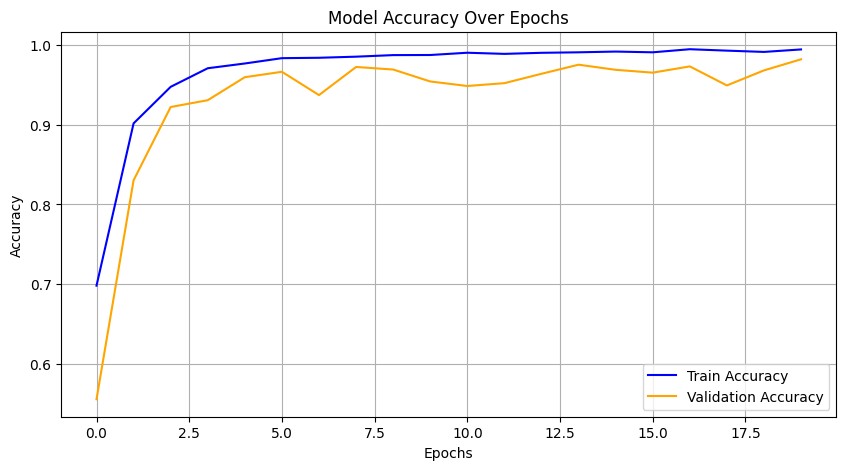

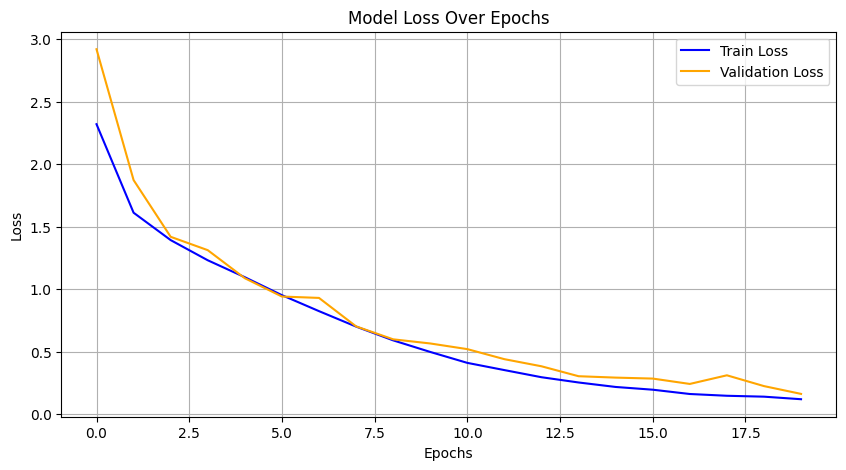

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history["categorical_accuracy"], label="Train Accuracy", color='blue')
plt.plot(history.history["val_categorical_accuracy"], label="Validation Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss", color='blue')
plt.plot(history.history["val_loss"], label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.grid(True)
plt.show()

In [7]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = mobileV2.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - categorical_accuracy: 0.9801 - loss: 0.1588
Test Loss: 0.1585
Test Accuracy: 0.9789


88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step


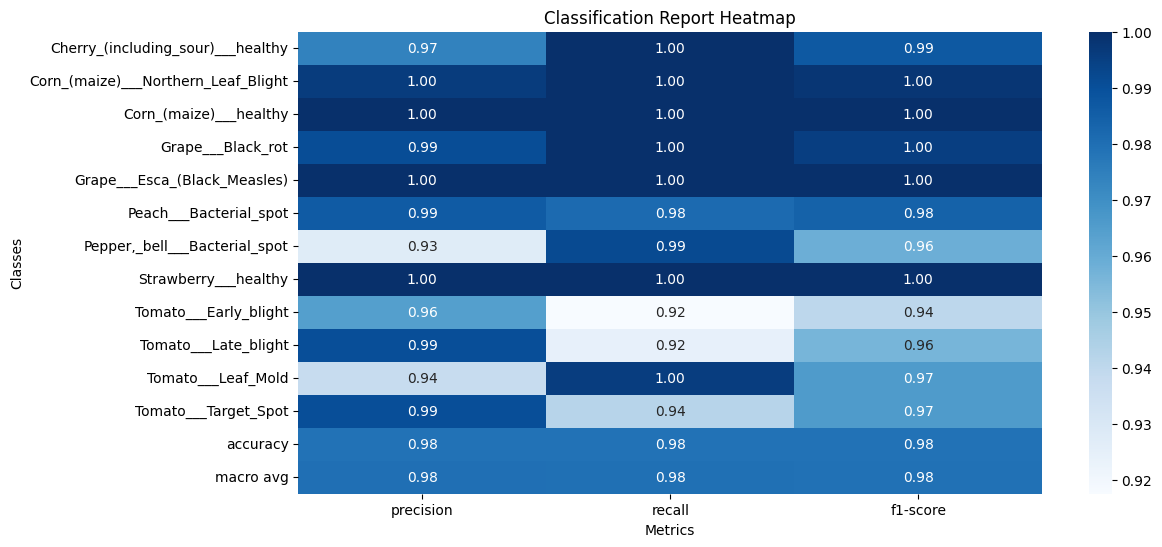

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

# Get the true labels and images from test_ds
y_true = []
images_list = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to label indices
    images_list.append(images)

# Convert true labels to numpy array
y_true = np.array(y_true)

# Flatten image batches into a single array
images_all = np.concatenate(images_list, axis=0)

# Make predictions in one go
y_pred_probs = mobileV2.predict(images_all)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class names
class_names = test_ds.class_names  

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot classification report as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()

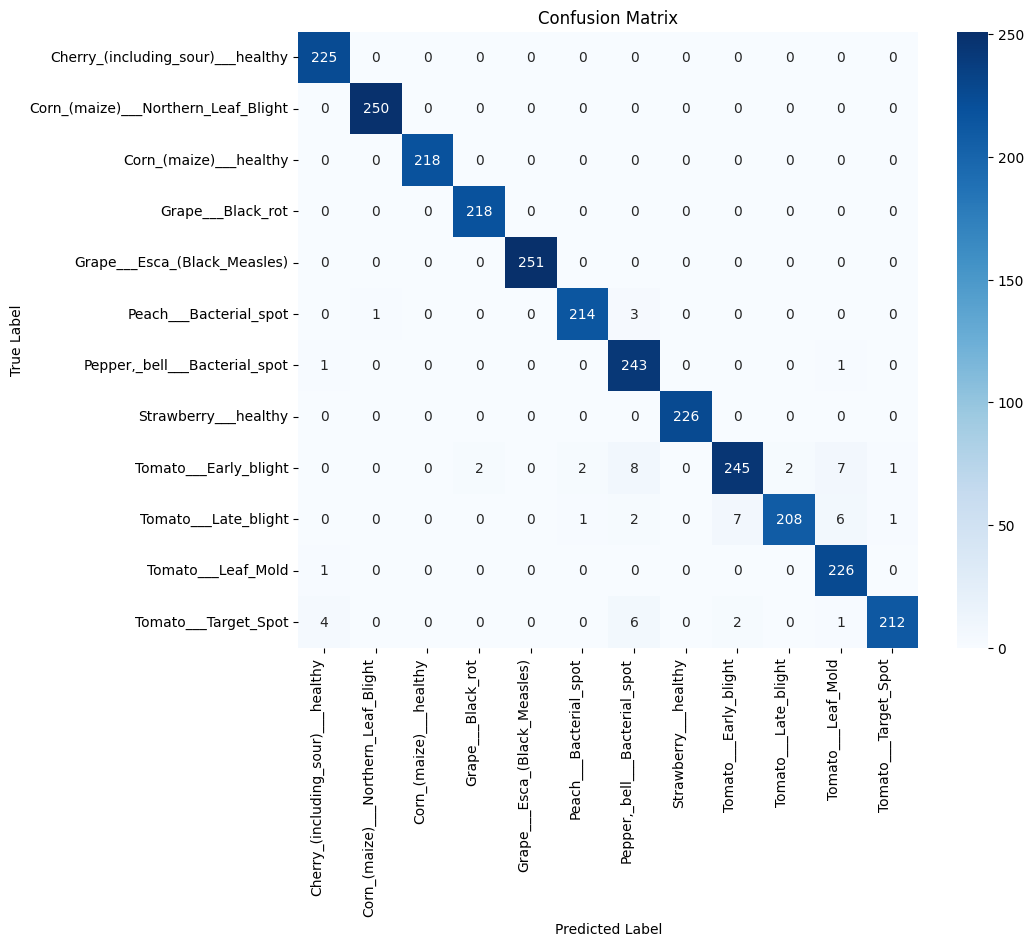

In [14]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.show()

In [15]:
mobileV2.save('C:/Users/leong/OneDrive/Desktop/24S2 NYP/EGT215 Computer Vision/UPDATED_CV_MODEL/Model Files/MobileNetV2.keras')